# Bulding Model To Identify Real And Fake News

## Importing Libraries

In [1]:
!pip install nltk

In [2]:
!pip install spacy
!pip install wordcloud

In [3]:
!python -m spacy download en_core_web_sm

2023-08-21 14:23:48.806503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 14:23:55.325690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import pandas as pd
import numpy as np
#imread means image read
from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB as MB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import re
import nltk
nltk.download('omw-1.4')
import spacy # language models
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer as ps
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

from datetime import datetime

import string # special operations on strings

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv


In [5]:
fake = pd.read_csv('Fake.csv',encoding='ISO-8859-1')
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obamas Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied Safe Zone Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving True.csv to True.csv


In [6]:
real = pd.read_csv('True.csv', encoding='ISO-8859-1', error_bad_lines=False) #skipping line 11067 due data discrepancy
real

Skipping line 11067: expected 4 fields, saw 8



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21411,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21412,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21413,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21414,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


## EDA

In [7]:
fake.info() #23481 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
real.info() #21416 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21416 entries, 0 to 21415
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21416 non-null  object
 1   text     21416 non-null  object
 2   subject  21416 non-null  object
 3   date     21416 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
real.shape, fake.shape

((21416, 4), (23481, 4))

In [10]:
fake.describe()
#count--> count of non null values
#unique--> total unique values or text
#top--> most common value
#freq--> most common value frequency

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [11]:
real.describe()

,title,text,subject,date
count,21416,21416,21416,21416
unique,20825,21191,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11271,182


In [12]:
#counting year wise date from real data
#counting unique years from date feature of real data
real["date"] = pd.to_datetime(real["date"])
yr_count = real["date"].dt.year.value_counts()
yr_count
#16701 news from 2017 and 4715 news from 2016

2017    16701
2016     4715
Name: date, dtype: int64

In [13]:
#creating year column in real data
real["year"] = real["date"].dt.year
real.head()

,title,text,subject,date,year
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,2017
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,2017
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,2017
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,2017
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,2017


In [14]:
#Datatype
real.dtypes

title              object
text               object
subject            object
date       datetime64[ns]
year                int64
dtype: object

In [15]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
year       0
dtype: int64

In [16]:
#checking duplicate rows
fake[fake.duplicated()].shape #3 duplicate rows

(3, 4)

In [17]:
fake.drop_duplicates(inplace=True)
fake[fake.duplicated()].shape

(0, 4)

In [18]:
fake.info() #23478 rows after dropping duplicate rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB


In [19]:
#checking duplicate rows
real[real.duplicated()].shape #206 are duplicate rows

(206, 5)

In [20]:
real.drop_duplicates(inplace=True)
real[real.duplicated()].shape

(0, 5)

In [21]:
real.info() #21210 rows after dropping duplicate rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21210 entries, 0 to 21415
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21210 non-null  object        
 1   text     21210 non-null  object        
 2   subject  21210 non-null  object        
 3   date     21210 non-null  datetime64[ns]
 4   year     21210 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 994.2+ KB


In [22]:
print('Unique values of subject in real dataset: \n', real['subject'].value_counts())
print('Unique values of subject in fake dataset: \n', fake['subject'].value_counts())

Unique values of subject in real dataset: 
 politicsNews    11219
worldnews        9991
Name: subject, dtype: int64
Unique values of subject in fake dataset: 
 News               9050
politics           6838
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64


In [23]:
# Adding new column to distribute Fake and Real news

# fake news represented by '0'
# real news represented by '1'

fake['target'] = '0'
real['target'] = '1'

In [24]:
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obamas Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [25]:
real.head()

,title,text,subject,date,year,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,2017,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,2017,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,2017,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,2017,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,2017,1


In [26]:
# Resetting index
data = pd.concat([fake,real]).reset_index(drop = True)
data.shape

(44688, 6)

In [27]:
data.head()

,title,text,subject,date,target,year
0,Donald Trump Sends Out Embarrassing New Year...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,NaN
3,Trump Is So Obsessed He Even Has Obamas Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,NaN


In [28]:
data.tail()

,title,text,subject,date,target,year
44683,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22 00:00:00,1,2017.0
44684,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22 00:00:00,1,2017.0
44685,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22 00:00:00,1,2017.0
44686,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22 00:00:00,1,2017.0
44687,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,2017-08-22 00:00:00,1,2017.0


In [29]:
# Shuffling the data

data = shuffle(data)
data = data.reset_index(drop = True)

In [30]:
data.head(10)

,title,text,subject,date,target,year
0,BOOM! CLINTON RAP: Pay My Foundation for the ...,,politics,"Nov 3, 2016",0,NaN
1,HAPPY MOTHERS DAY&Your First Grader Just Rate...,Rate your mom for Mother s Day sounds like the...,politics,"May 11, 2015",0,NaN
2,Trump orders review of visa program to encoura...,"KENOSHA, Wis. (Reuters) - President Donald Tru...",politicsNews,2017-04-18 00:00:00,1,2017.0
3,YOUNG MAN DELIVERS POWERFUL Message To Liberal...,Wow! This young Asian student nails it! He spe...,left-news,"Feb 16, 2017",0,NaN
4,Zimbabwe court frees activist pastor arrested ...,HARARE (Reuters) - A Zimbabwean court on Tuesd...,worldnews,2017-09-26 00:00:00,1,2017.0
5,Puerto Rico opens arms to refugees from Irma's...,"SAN JUAN, Puerto Rico (Reuters) - Saddled with...",worldnews,2017-09-13 00:00:00,1,2017.0
6,"Nine dead, seven missing after Irma hits Frenc...",PARIS (Reuters) - Nine people have been killed...,worldnews,2017-09-08 00:00:00,1,2017.0
7,Philippines hunts for possible new Islamic Sta...,MANILA (Reuters) - Philippine authorities were...,worldnews,2017-11-06 00:00:00,1,2017.0
8,THE LIST OF WHOS WHO TAKING ADVANTAGE OF FAIL...,Like a spoiled child on a spending spree with ...,politics,"Jul 14, 2015",0,NaN
9,Paul Ryan Wants To Make This Healthcare Night...,"On Wednesday, Republican House Speaker Paul Ry...",News,"April 28, 2016",0,NaN


In [31]:
data = data.drop('year', axis=1)
data.columns

Index(['title', 'text', 'subject', 'date', 'target'], dtype='object')

In [32]:
data['subject'].value_counts()

politicsNews       11219
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [33]:
data['target'].value_counts() #data is almost balanced

0    23478
1    21210
Name: target, dtype: int64

In [34]:
data.isnull().sum() #checking missing values

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [35]:
data[data.duplicated()].shape

(0, 5)

## Visualization

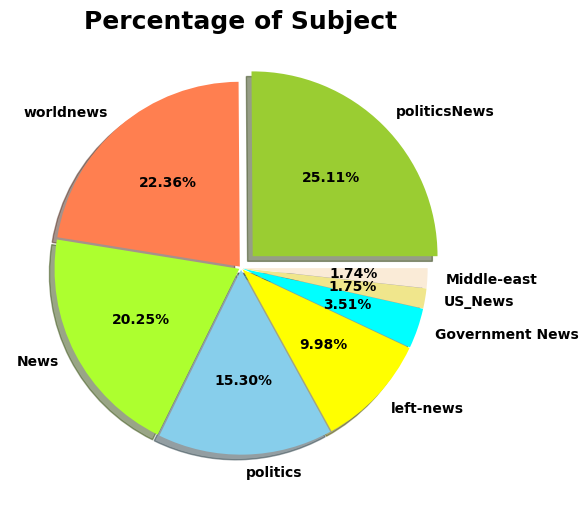

In [ ]:
#distribution of subject percentage wise in data
t1 = data['subject'].value_counts().head(10)
t1.index
plt.figure(figsize = (6,6))
plt.pie(t1, labels=t1.index,
        explode = [0.09,0.01,0.01,0.01,0.01,0.01,0.01,0.01],
        autopct= '%.2f%%', textprops = {'size' : 10, 'fontweight': 'bold'},
        colors = ['yellowgreen', 'coral', 'greenyellow', 'SkyBlue', 'yellow', 'cyan', 'khaki', 'antiquewhite'], shadow=True)

plt.title('Percentage of Subject', fontsize = 18, fontweight = 'bold');

Text(0.5, 1.0, 'Count of Fake and Real News')

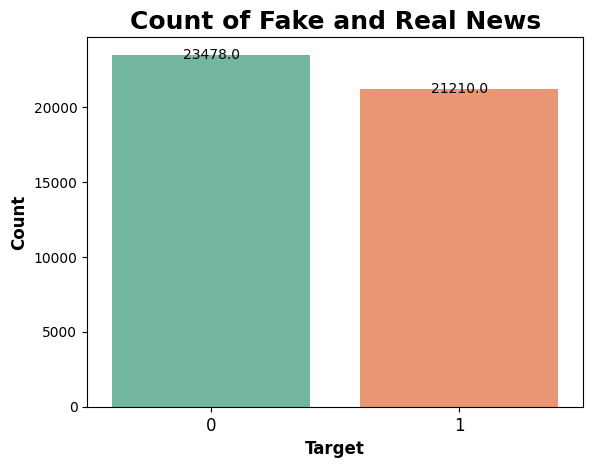

In [ ]:
#count of fake and real news in data
tarplot=sns.countplot(x='target', data=data, palette='Set2',
              order=data['target'].value_counts().index)
plt.xlabel('Target', size = 12, fontweight='bold')
plt.ylabel('Count', size = 12, fontweight='bold')
for p in tarplot.patches:
    tarplot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.xticks(fontsize = 12)
plt.title('Count of Fake and Real News', fontsize = 18, fontweight = 'bold')

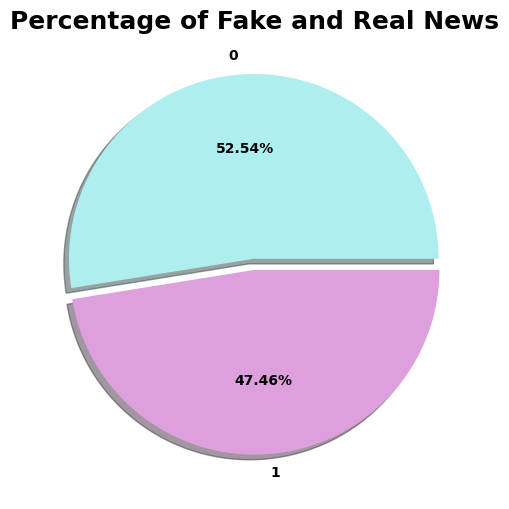

In [ ]:
#distribution of fake and real news percentage wise
t1 = data['target'].value_counts().head(10)
t1.index
plt.figure(figsize = (6,6))
plt.pie(t1, labels=t1.index,
        explode = [0.05,0.01],
        autopct= '%.2f%%', textprops = {'size' : 10, 'fontweight': 'bold'},
        colors = ['paleturquoise', 'plum'], shadow=True)
plt.title('Percentage of Fake and Real News', fontsize = 18, fontweight = 'bold');

Text(0.5, 1.0, 'Subject in True Data')

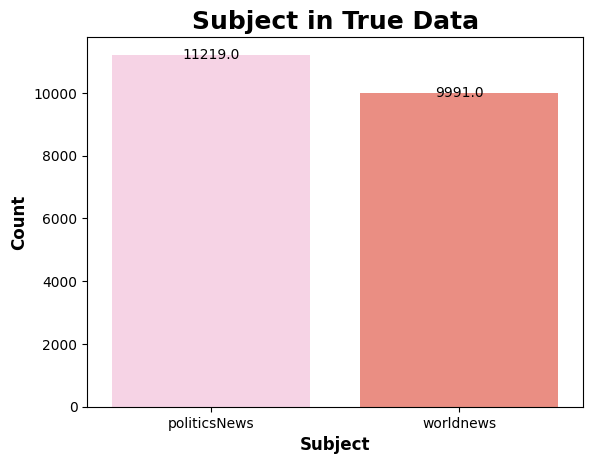

In [ ]:
#checking categories of subject in true data
axis=sns.countplot(x = 'subject', data = real, palette='Set3_r')
plt.xlabel('Subject', size = 12, fontweight='bold')
plt.ylabel('Count', size = 12, fontweight='bold')
for p in axis.patches:
    axis.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.title('Subject in True Data', fontsize = 18, fontweight = 'bold')

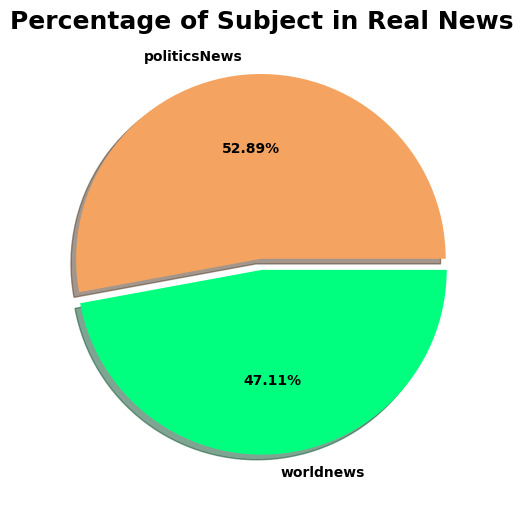

In [ ]:
#distribution of subject in real news percentage wise
t2 = real['subject'].value_counts().head(10)
t2.index
plt.figure(figsize = (6,6))
plt.pie(t2, labels=t2.index,
        explode = [0.05,0.01],
        autopct= '%.2f%%', textprops = {'size' : 10, 'fontweight': 'bold'},
        colors = ['sandybrown', 'springgreen'], shadow=True)
plt.title('Percentage of Subject in Real News', fontsize = 18, fontweight = 'bold');

[Text(0, 0, 'News'),
 Text(1, 0, 'Politics'),
 Text(2, 0, 'Government News'),
 Text(3, 0, 'US_News'),
 Text(4, 0, 'Middle-East'),
 Text(5, 0, 'Left-News')]

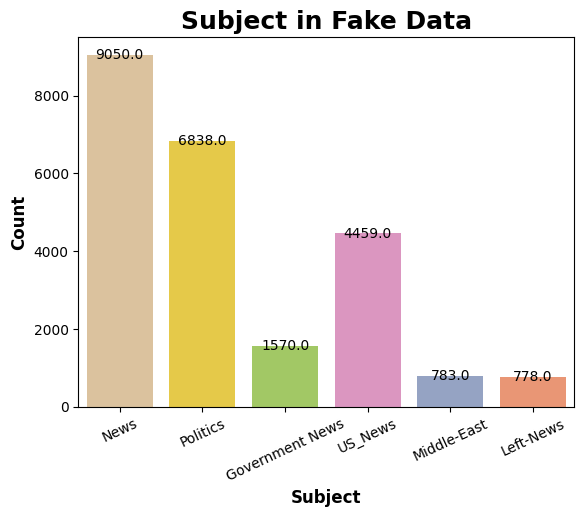

In [ ]:
#checking categories of subject in fake data
axis=sns.countplot(x = 'subject', data = fake, palette='Set2_r')
plt.xlabel('Subject', size = 12, fontweight='bold')
plt.ylabel('Count', size = 12, fontweight='bold')
for p in axis.patches:
    axis.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.title('Subject in Fake Data', fontsize = 18, fontweight = 'bold')
axis.set_xticklabels(['News', 'Politics', 'Government News', 'US_News',
                    'Middle-East', 'Left-News'], rotation=25)

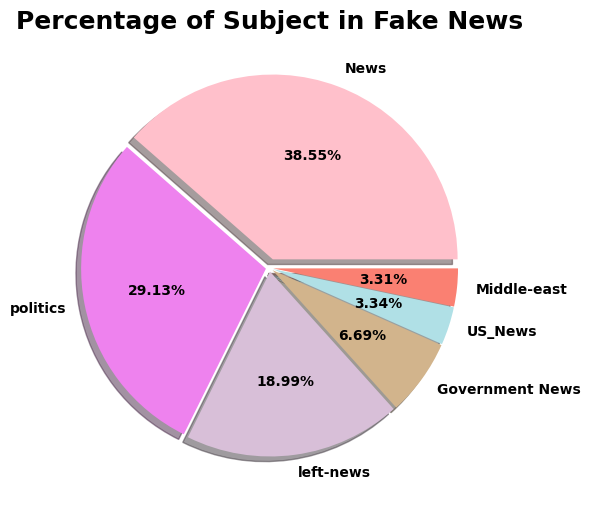

In [ ]:
#distribution of subject in fake news percentage wise
t3 = fake['subject'].value_counts().head(10)
t3.index
plt.figure(figsize = (6,6))
plt.pie(t3, labels=t3.index,
        explode = [0.05, 0.02, 0.02, 0.02, 0.02, 0.02],
        autopct= '%.2f%%', textprops = {'size' : 10, 'fontweight': 'bold'},
        colors = ['pink', 'violet', 'thistle', 'tan', 'powderblue', 'salmon'], shadow=True)
plt.title('Percentage of Subject in Fake News', fontsize = 18, fontweight = 'bold');

politicsNews       11219
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Subject in True and Fake Data')

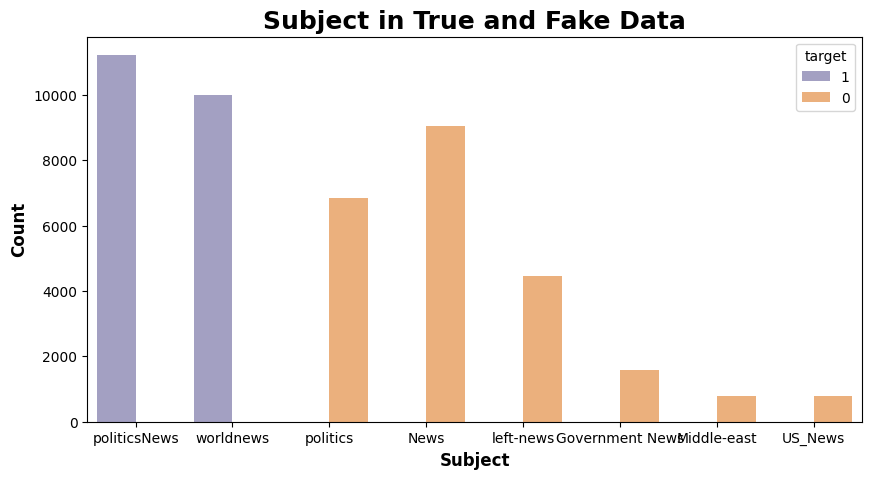

In [ ]:
#Distribution of the subject according to true and fake data
print(data.subject.value_counts())
plt.figure(figsize= (10, 5))

ax= sns.countplot(x= "subject", hue= "target", data= data, palette= "tab20c_r")
plt.xlabel('Subject', size = 12, fontweight='bold')
plt.ylabel('Count', size = 12, fontweight='bold')
plt.title("Subject in True and Fake Data", fontsize = 18, fontweight = 'bold')

politicsNews    11219
worldnews        9991
Name: subject, dtype: int64


Text(0.5, 1.0, 'Year and Subject Count in Real Data')

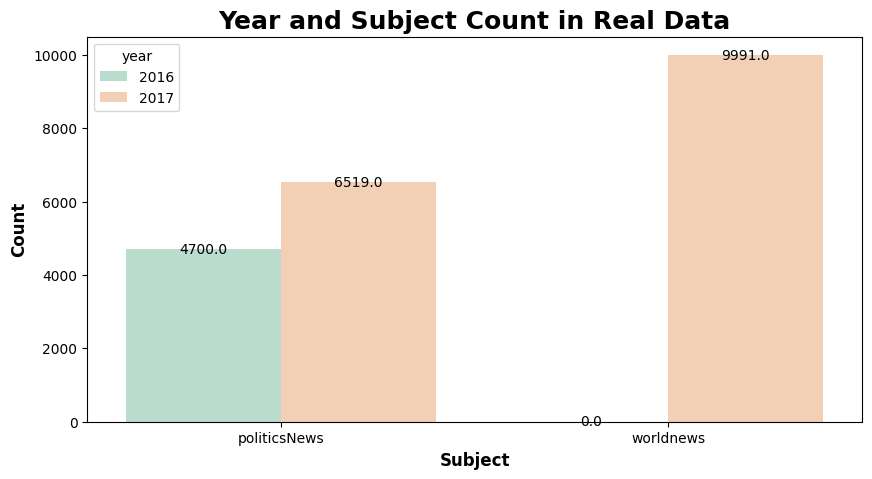

In [ ]:
#Distribution of the subject according to year from real data
print(real.subject.value_counts())
plt.figure(figsize= (10, 5))

bx= sns.countplot(x= "subject", hue= "year", data= real, palette= "Pastel2")
plt.xlabel('Subject', size = 12, fontweight='bold')
plt.ylabel('Count', size = 12, fontweight='bold')
for p in bx.patches:
    bx.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
plt.title("Year and Subject Count in Real Data", fontsize = 18, fontweight = 'bold')

Text(0, 0.5, 'Count')

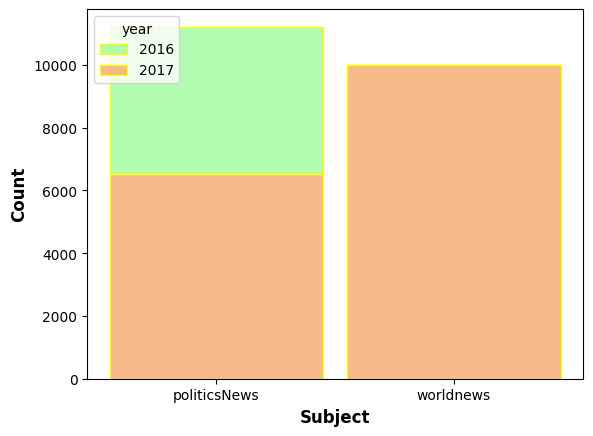

In [ ]:
#Distribution of the subject according to year from real data
bx = sns.histplot(real, x='subject', hue='year', multiple='stack', palette=['#98FB98', '#F4A460'],
    edgecolor='yellow', shrink=0.9)
plt.xlabel('Subject', size = 12, fontweight='bold')
plt.ylabel('Count', size = 12, fontweight='bold')

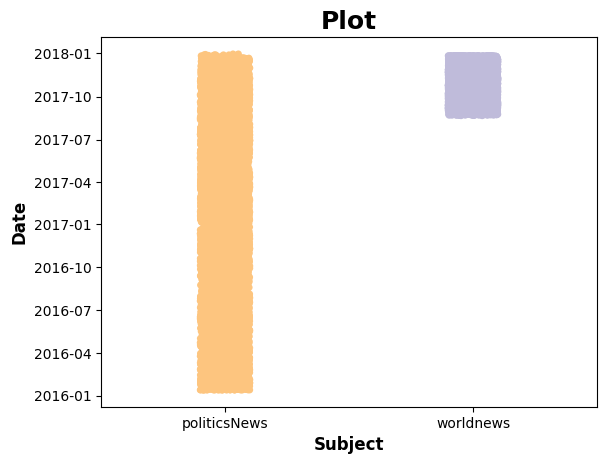

In [ ]:
sns.stripplot(x = 'subject', y = 'date', data = real, palette='PuOr');
plt.title('Plot', fontsize = 18, fontweight = 'bold');
plt.xlabel('Subject', size = 12, fontweight='bold')
plt.ylabel('Date', size = 12, fontweight='bold');

## Data Processing

In [36]:
data.head()

,title,text,subject,date,target
0,BOOM! CLINTON RAP: Pay My Foundation for the ...,,politics,"Nov 3, 2016",0
1,HAPPY MOTHERS DAY&Your First Grader Just Rate...,Rate your mom for Mother s Day sounds like the...,politics,"May 11, 2015",0
2,Trump orders review of visa program to encoura...,"KENOSHA, Wis. (Reuters) - President Donald Tru...",politicsNews,2017-04-18 00:00:00,1
3,YOUNG MAN DELIVERS POWERFUL Message To Liberal...,Wow! This young Asian student nails it! He spe...,left-news,"Feb 16, 2017",0
4,Zimbabwe court frees activist pastor arrested ...,HARARE (Reuters) - A Zimbabwean court on Tuesd...,worldnews,2017-09-26 00:00:00,1


In [37]:
#combined features data of text, title
data['text'] = data['title'] + " " + data['text']
del data['title']
data.head()

,text,subject,date,target
0,BOOM! CLINTON RAP: Pay My Foundation for the ...,politics,"Nov 3, 2016",0
1,HAPPY MOTHERS DAY&Your First Grader Just Rate...,politics,"May 11, 2015",0
2,Trump orders review of visa program to encoura...,politicsNews,2017-04-18 00:00:00,1
3,YOUNG MAN DELIVERS POWERFUL Message To Liberal...,left-news,"Feb 16, 2017",0
4,Zimbabwe court frees activist pastor arrested ...,worldnews,2017-09-26 00:00:00,1


In [38]:
data["text"][0]

'BOOM! CLINTON RAP: \x18Pay My Foundation for the Keys to the Nation\x19 [VIDEO]  '

In [39]:
def prepreprocessing(text):
    text = text.lower() #converting text to lowercase
    text = re.sub(r'https?:\S+|www\S+', '', text, flags=re.MULTILINE)  #removing urls
    text = re.sub(r'\@\S+|\#', '', text)  #removing special characters
    text = re.sub(r'[^\w\s]', '', text)  #removing punctuations
    text = re.sub(r'\d+', '', text)#removing numbers
    text_tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in text_tokens if not word in stop_words] #removing stop words

    wnl = WordNetLemmatizer()
    lemma_words = [wnl.lemmatize(word) for word in filtered_tokens] #lemmatization

    return " ".join(lemma_words)

data['text'] = data['text'].apply(prepreprocessing)
data['text'][0]#removed punctuations, uppercase text and special characters

'boom clinton rap pay foundation key nation video'

In [40]:
data.head()

,text,subject,date,target
0,boom clinton rap pay foundation key nation video,politics,"Nov 3, 2016",0
1,happy mother dayyour first grader rated mommy ...,politics,"May 11, 2015",0
2,trump order review visa program encourage hiri...,politicsNews,2017-04-18 00:00:00,1
3,young man delivers powerful message liberal pu...,left-news,"Feb 16, 2017",0
4,zimbabwe court free activist pastor arrested s...,worldnews,2017-09-26 00:00:00,1


In [41]:
data['num_char'] = data['text'].apply(len)
data.head() #calculating number of characters

,text,subject,date,target,num_char
0,boom clinton rap pay foundation key nation video,politics,"Nov 3, 2016",0,48
1,happy mother dayyour first grader rated mommy ...,politics,"May 11, 2015",0,2123
2,trump order review visa program encourage hiri...,politicsNews,2017-04-18 00:00:00,1,3670
3,young man delivers powerful message liberal pu...,left-news,"Feb 16, 2017",0,1063
4,zimbabwe court free activist pastor arrested s...,worldnews,2017-09-26 00:00:00,1,796


In [42]:
data['num_words'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))
data.head() #calculating number of words

,text,subject,date,target,num_char,num_words
0,boom clinton rap pay foundation key nation video,politics,"Nov 3, 2016",0,48,8
1,happy mother dayyour first grader rated mommy ...,politics,"May 11, 2015",0,2123,290
2,trump order review visa program encourage hiri...,politicsNews,2017-04-18 00:00:00,1,3670,505
3,young man delivers powerful message liberal pu...,left-news,"Feb 16, 2017",0,1063,161
4,zimbabwe court free activist pastor arrested s...,worldnews,2017-09-26 00:00:00,1,796,107


In [43]:
data['target'] = data['target'].astype(int)
data.dtypes

text         object
subject      object
date         object
target        int64
num_char      int64
num_words     int64
dtype: object

<Axes: xlabel='num_char', ylabel='Count'>

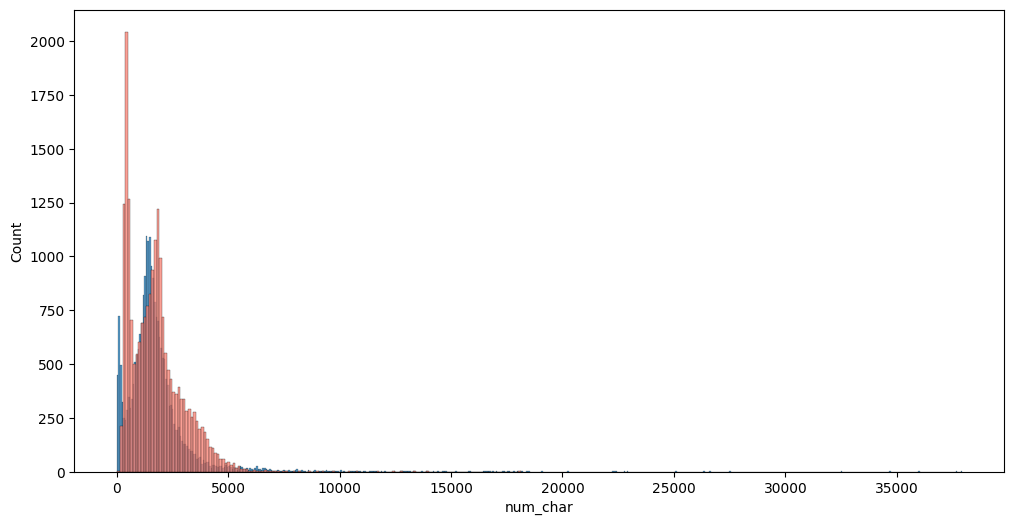

In [44]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['target'] == 0]['num_char'])
sns.histplot(data[data['target'] == 1]['num_char'],color='salmon')

<Axes: xlabel='num_words', ylabel='Count'>

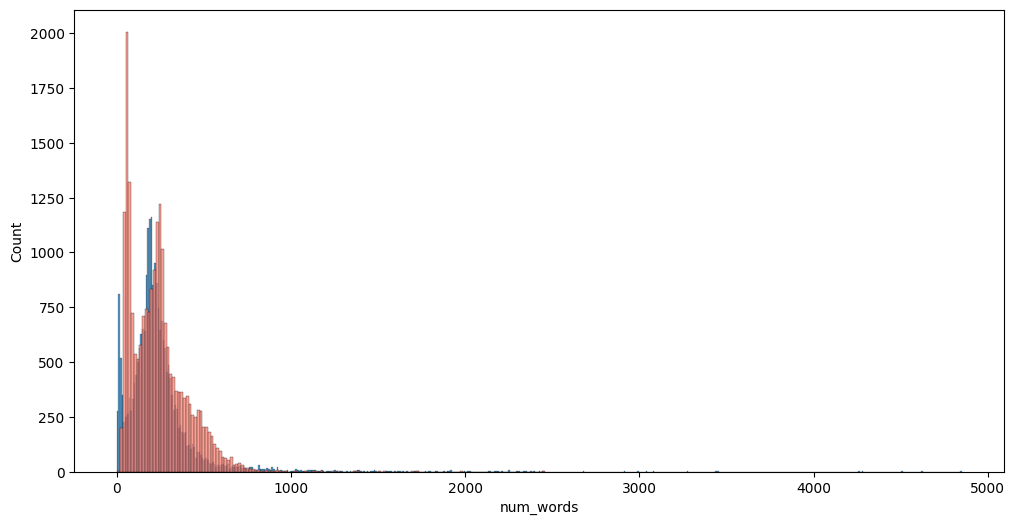

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['target'] == 0]['num_words'])
sns.histplot(data[data['target'] == 1]['num_words'],color='salmon')

In [ ]:
data.head()

,text,subject,date,target,num_char,num_words
0,nearly half briton back trump state visit youg...,politicsNews,2017-02-01 00:00:00,1,1174,165
1,south korea moon japan abe agree raise pressur...,worldnews,2017-08-30 00:00:00,1,449,62
2,dc bar owner seth rich last seen drop bombshel...,politics,"May 22, 2017",0,5373,764
3,factbox u senate house tax proposal differ reu...,politicsNews,2017-11-09 00:00:00,1,2170,301
4,busted jeb bush campaign used plant attack tru...,politics,"Oct 13, 2015",0,1278,168


In [ ]:
text_corpus = []
for news in data[data['target'] == 1]['text'].tolist():
    for word in news.split():
        text_corpus.append(word)

In [ ]:
len(text_corpus)

4963698

In [ ]:
Counter(text_corpus).most_common(30)

[('said', 97860),
 ('trump', 59121),
 ('u', 44690),
 ('state', 36764),
 ('would', 31382),
 ('reuters', 28167),
 ('president', 27201),
 ('republican', 22941),
 ('government', 19580),
 ('year', 19258),
 ('house', 18225),
 ('new', 17497),
 ('also', 15764),
 ('united', 15401),
 ('people', 15234),
 ('party', 15212),
 ('official', 14912),
 ('election', 14382),
 ('told', 14112),
 ('country', 14002),
 ('could', 13758),
 ('one', 13018),
 ('say', 12947),
 ('last', 12564),
 ('washington', 12458),
 ('two', 11696),
 ('campaign', 11321),
 ('group', 11239),
 ('leader', 10992),
 ('court', 10912)]

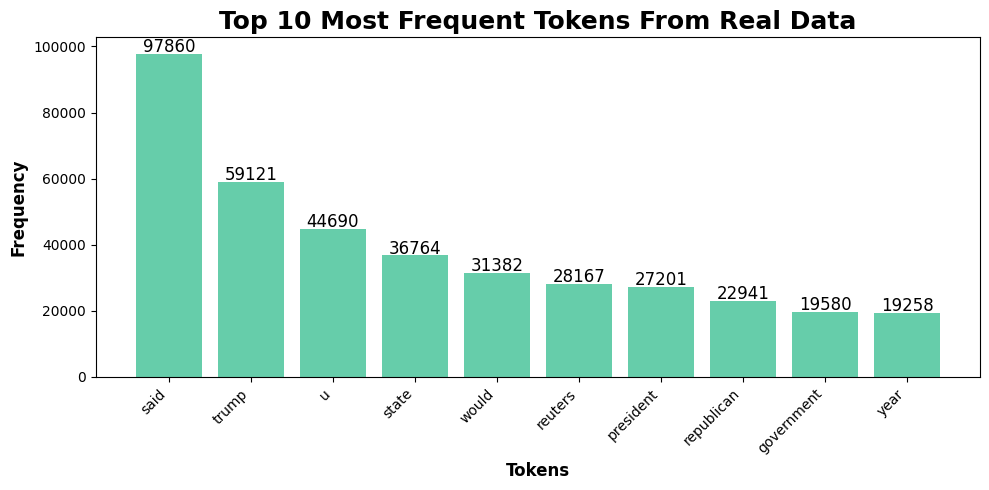

In [ ]:
tokenfreq10 = Counter(text_corpus).most_common(10)
tokenfreq10, frequencies = zip(*tokenfreq10)

#barchart for top 10 frequent tokens
fig, ax =  plt.subplots(figsize = (10, 5))
ax.bar(tokenfreq10, frequencies, color='mediumaquamarine')
for bar in ax.patches:
    ax.annotate(text = bar.get_height(),
                  xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='center', size=12, xytext=(0, 5), textcoords='offset points')
plt.xlabel('Tokens', size = 12, fontweight='bold')
plt.ylabel('Frequency', size = 12, fontweight='bold')
plt.title('Top 10 Most Frequent Tokens From Real Data', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
data.dtypes

text         object
subject      object
date         object
target        int64
num_char      int64
num_words     int64
dtype: object

In [ ]:
fake_corpus = []
for news in data[data['target'] == 0]['text'].tolist():
    for word in news.split():
        fake_corpus.append(word)

In [ ]:
len(fake_corpus)

5634377

In [ ]:
Counter(fake_corpus).most_common(30)

[('trump', 82999),
 ('said', 31210),
 ('president', 27283),
 ('people', 26563),
 ('one', 24346),
 ('would', 23678),
 ('u', 23420),
 ('state', 22576),
 ('clinton', 19783),
 ('obama', 19627),
 ('like', 18557),
 ('time', 18116),
 ('donald', 18061),
 ('video', 16991),
 ('republican', 16903),
 ('american', 16708),
 ('say', 16167),
 ('hillary', 15777),
 ('year', 15574),
 ('also', 15268),
 ('new', 15051),
 ('news', 15002),
 ('image', 14186),
 ('white', 13996),
 ('even', 13898),
 ('get', 13145),
 ('right', 12847),
 ('make', 12279),
 ('know', 12145),
 ('woman', 11841)]

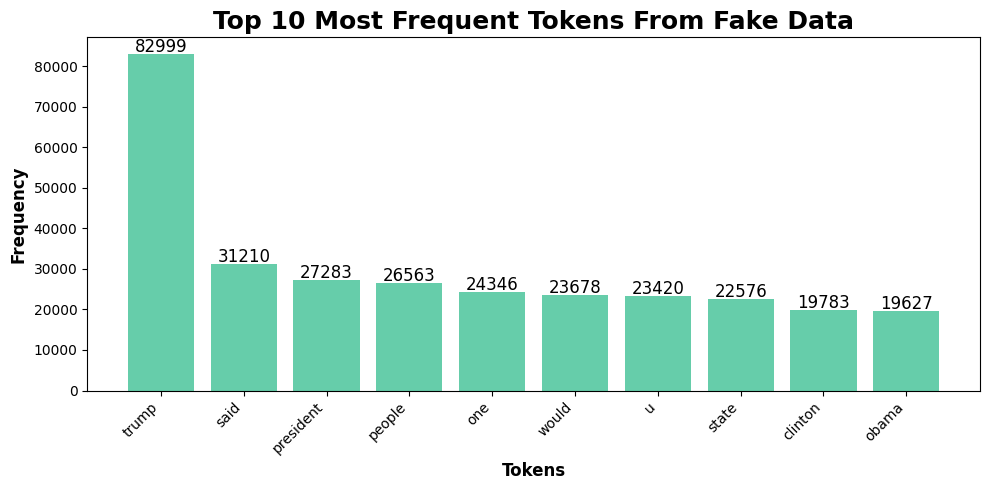

In [ ]:
tokenfreq = Counter(fake_corpus).most_common(10)
tokenfreq, frequency = zip(*tokenfreq)

#barchart for top 10 frequent tokens
fig, ax =  plt.subplots(figsize = (10, 5))
ax.bar(tokenfreq, frequency, color='mediumaquamarine')
for bar in ax.patches:
    ax.annotate(text = bar.get_height(),
                  xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='center', size=12, xytext=(0, 5), textcoords='offset points')
plt.xlabel('Tokens', size = 12, fontweight='bold')
plt.ylabel('Frequency', size = 12, fontweight='bold')
plt.title('Top 10 Most Frequent Tokens From Fake Data', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## WordCloud

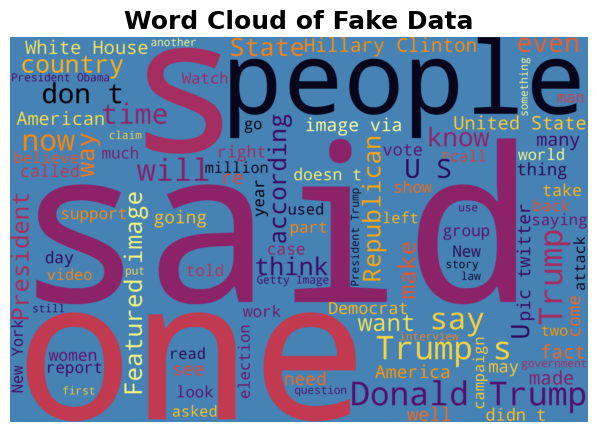

In [ ]:
plt.figure(figsize=(15,5))
wordcloud= WordCloud(background_color='steelblue',
                     max_words=100,colormap='inferno', width = 3000,
                     height = 2000, stopwords= STOPWORDS).generate(" ".join(fake['text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Fake Data', fontsize = 18, fontweight = 'bold')
plt.show()

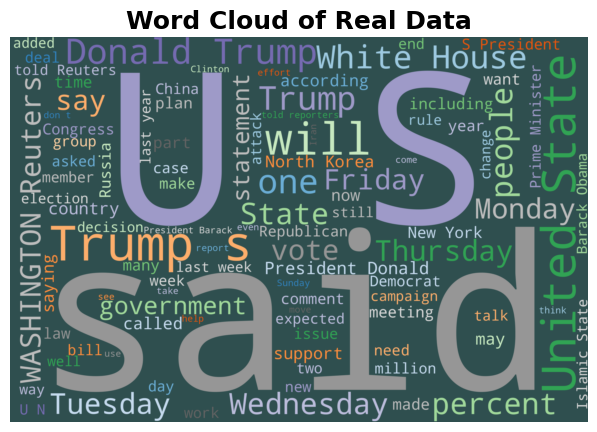

In [ ]:
plt.figure(figsize=(15,5))
wordcloud= WordCloud(background_color='darkslategrey',
                     max_words=100,colormap='tab20c', width = 3000,
                     height = 2000, stopwords= STOPWORDS).generate(" ".join(real['text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Real Data', fontsize = 18, fontweight = 'bold')
plt.show()

# Train-Test Split

In [45]:
data.head()

,text,subject,date,target,num_char,num_words
0,boom clinton rap pay foundation key nation video,politics,"Nov 3, 2016",0,48,8
1,happy mother dayyour first grader rated mommy ...,politics,"May 11, 2015",0,2123,290
2,trump order review visa program encourage hiri...,politicsNews,2017-04-18 00:00:00,1,3670,505
3,young man delivers powerful message liberal pu...,left-news,"Feb 16, 2017",0,1063,161
4,zimbabwe court free activist pastor arrested s...,worldnews,2017-09-26 00:00:00,1,796,107


In [46]:
y_df = data['target']
x_df = data['text']

In [47]:
# Splitting the data into test data and train data
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size = 0.3, random_state=0)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31281,), (31281,), (13407,), (13407,))

# TF-IDF Vectorizer

In [48]:
# Creating TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=500, max_df = 0.5, smooth_idf=True)#taking values whose weight is<0.5
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [49]:
x_train_tfidf.shape, y_train.shape, x_test_tfidf.shape, y_test.shape

((31281, 500), (31281,), (13407, 500), (13407,))

## Naive Bayes

Multinomial Naive Bayes

In [66]:
Mnbmodel=MB()
Mnbmodel.fit(x_train_tfidf, y_train) #fitting a model

MultinomialNB()

In [67]:
naive_pred = Mnbmodel.predict(x_test_tfidf) #predicting values

In [68]:
accn_score = round(accuracy_score(y_test, naive_pred)*100, 2)
print(accn_score) #checking accuracy

91.71


NB Model Evaluation

In [69]:
print(classification_report(y_test, naive_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7081
           1       0.91      0.91      0.91      6326

    accuracy                           0.92     13407
   macro avg       0.92      0.92      0.92     13407
weighted avg       0.92      0.92      0.92     13407



In [70]:
naiveb_matrix = confusion_matrix(y_test, naive_pred)
print (naiveb_matrix) #12286 correct predictions
#1121 wrong predictions

[[6525  556]
 [ 555 5771]]


Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes')

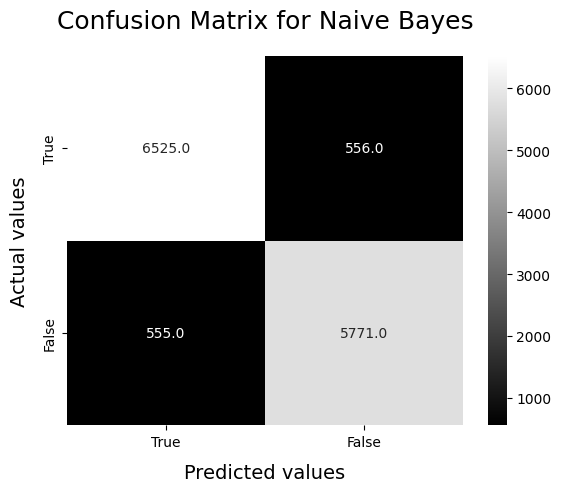

In [71]:
sns.heatmap(naiveb_matrix, annot=True,cmap = 'binary_r',fmt = '.1f',
xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for Naive Bayes", fontdict = {'size':18}, pad = 20)

## Logistic Regression

In [72]:
#Logistic regression and fit the model
classifier = LogisticRegression()
classifier.fit(x_train_tfidf,y_train)

LogisticRegression()

In [73]:
l_pred = classifier.predict(x_test_tfidf)

In [74]:
accl_score = round(accuracy_score(y_test, l_pred)*100, 2)
print(accl_score)

98.16


Linear Regression Model Evaluation

In [75]:
print(classification_report(y_test, l_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7081
           1       0.98      0.99      0.98      6326

    accuracy                           0.98     13407
   macro avg       0.98      0.98      0.98     13407
weighted avg       0.98      0.98      0.98     13407



In [76]:
logistic_matrix = confusion_matrix(y_test, l_pred)
print (logistic_matrix) #13181 correct predictions
#226 wrong predictions

[[6926  155]
 [  92 6234]]


Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

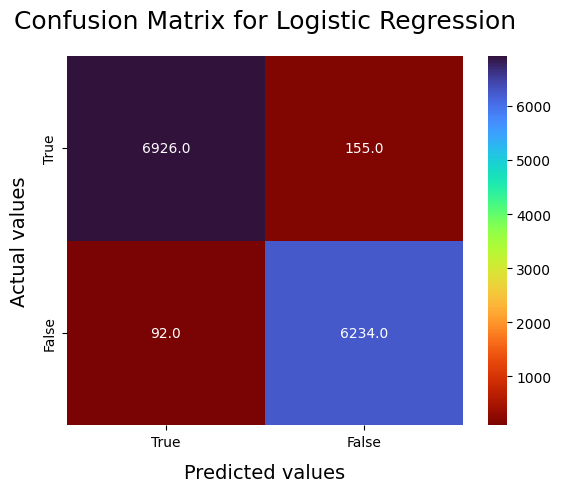

In [77]:
sns.heatmap(logistic_matrix, annot=True,cmap = 'turbo_r',fmt = '.1f',
xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for Logistic Regression", fontdict = {'size':18}, pad = 20)

## Decision Tree

In [78]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train_tfidf, y_train)

DecisionTreeClassifier()

In [79]:
preds = dtc.predict(x_test_tfidf)

In [80]:
accd_score = round(accuracy_score(y_test, preds)*100, 2)
print(accd_score)

99.16


Decision Tree Model Evaluation

In [81]:
decision_matrix = confusion_matrix(y_test, preds)
print (decision_matrix) #13300 correct predictions
#98 wrong predictions

[[7030   51]
 [  61 6265]]


In [82]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7081
           1       0.99      0.99      0.99      6326

    accuracy                           0.99     13407
   macro avg       0.99      0.99      0.99     13407
weighted avg       0.99      0.99      0.99     13407



Text(0.5, 1.0, 'Confusion Matrix for Decision Tree')

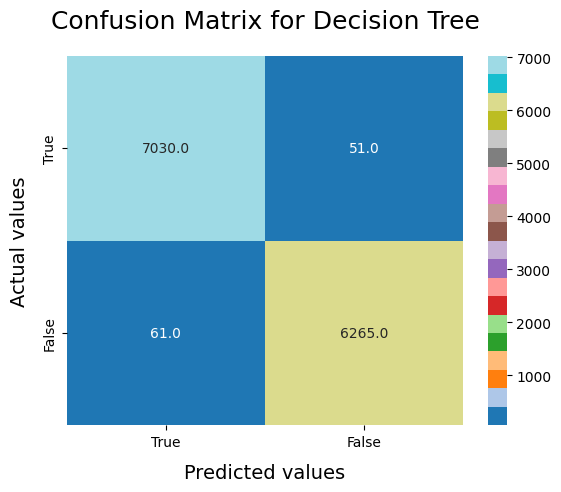

In [83]:
sns.heatmap(decision_matrix, annot=True,cmap = 'tab20',fmt = '.1f',
xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for Decision Tree", fontdict = {'size':18}, pad = 20)

## KNN

In [ ]:
#Randomized Search CV checking for hyperparameters
neighbors = np.array(range(1,40))
grid_param = dict(n_neighbors=neighbors)
KNN = KNeighborsClassifier()
rsc = RandomizedSearchCV(KNN, grid_param)
rsc.fit(x_train_tfidf, y_train) #fitting a model

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])})

In [ ]:
#best accuracy score
print(rsc.best_score_)
print(rsc.best_params_)

0.8649338929657097
{'n_neighbors': 36}


In [51]:
KNN_model = KNeighborsClassifier(n_neighbors=36)
KNN_model.fit(x_train_tfidf,y_train) #fitting a model with best parameter

KNeighborsClassifier(n_neighbors=36)

In [52]:
#Predicting on test data
k_preds = KNN_model.predict(x_test_tfidf) # predicting on test data set

In [53]:
acck_score = round(accuracy_score(y_test,k_preds)*100, 2)
print(acck_score)

88.15


KNN Model Evaluation

In [54]:
print(classification_report(y_test,k_preds))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      7081
           1       0.88      0.87      0.87      6326

    accuracy                           0.88     13407
   macro avg       0.88      0.88      0.88     13407
weighted avg       0.88      0.88      0.88     13407



In [55]:
knn_matrix = confusion_matrix(y_test,k_preds)
print (knn_matrix) #11649 correct predictions
#1758 wrong predictions

[[6324  757]
 [ 832 5494]]


Text(0.5, 1.0, 'Confusion Matrix for KNN')

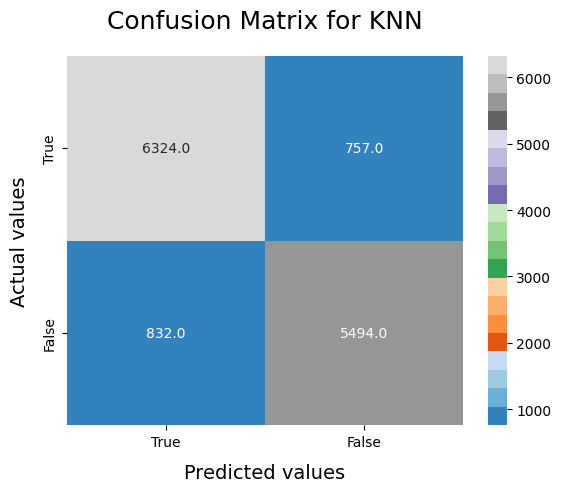

In [56]:
sns.heatmap(knn_matrix, annot=True,cmap = 'tab20c',fmt = '.1f',
xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for KNN", fontdict = {'size':18}, pad = 20)

# Random Forest

Randomized Search CV

In [ ]:
rfc = RandomForestClassifier()
para_grid=[{'n_estimators':[100, 150],'random_state':[7, 9], 'max_features':[3, 4]}]
#n_estimators=number of trees, #max_features=number of features
rfcsv=RandomizedSearchCV(rfc, para_grid, cv=10, verbose=300) #verbose controls output
#cv=10 means 10 folds
rfcsv.fit(x_train_tfidf, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START max_features=3, n_estimators=100, random_state=7...........
[CV 1/10; 1/8] END max_features=3, n_estimators=100, random_state=7;, score=0.987 total time=   4.8s
[CV 2/10; 1/8] START max_features=3, n_estimators=100, random_state=7...........
[CV 2/10; 1/8] END max_features=3, n_estimators=100, random_state=7;, score=0.981 total time=   4.0s
[CV 3/10; 1/8] START max_features=3, n_estimators=100, random_state=7...........
[CV 3/10; 1/8] END max_features=3, n_estimators=100, random_state=7;, score=0.985 total time=   4.6s
[CV 4/10; 1/8] START max_features=3, n_estimators=100, random_state=7...........
[CV 4/10; 1/8] END max_features=3, n_estimators=100, random_state=7;, score=0.986 total time=   4.1s
[CV 5/10; 1/8] START max_features=3, n_estimators=100, random_state=7...........
[CV 5/10; 1/8] END max_features=3, n_estimators=100, random_state=7;, score=0.988 total time=   4.4s
[CV 6/10; 1/8] START max_feat

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions=[{'max_features': [3, 4],
                                         'n_estimators': [100, 150],
                                         'random_state': [7, 9]}],
                   verbose=300)

In [ ]:
rfcsv.best_params_, rfcsv.best_score_

({'random_state': 9, 'n_estimators': 150, 'max_features': 4},
 0.9890668231109192)

In [57]:
kfold = KFold(n_splits=10, random_state=9, shuffle=True)

model_r = RandomForestClassifier(n_estimators=150, max_features=4)
model_r.fit(x_train_tfidf, y_train) #fitting amodel with best parameters

rf_preds = model_r.predict(x_test_tfidf) #predicting values

accrf_score = round(accuracy_score(y_test, rf_preds)*100, 2) #checking accuracy
print(accrf_score)

98.89


Random Forest Model Evaluation

In [58]:
print(classification_report(y_test,rf_preds))
rf_matrix = confusion_matrix(y_test, rf_preds)
print(rf_matrix) #13260 correct predictions
#147 wrong predictions

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7081
           1       0.99      0.99      0.99      6326

    accuracy                           0.99     13407
   macro avg       0.99      0.99      0.99     13407
weighted avg       0.99      0.99      0.99     13407

[[7009   72]
 [  77 6249]]


Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

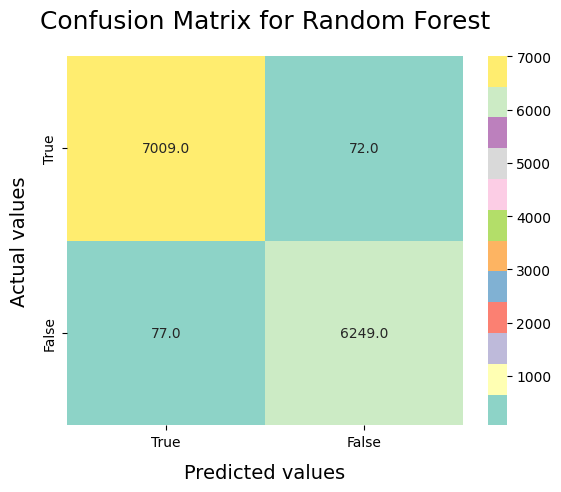

In [59]:
sns.heatmap(rf_matrix, annot=True,cmap = 'Set3',fmt = '.1f',
xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for Random Forest", fontdict = {'size':18}, pad = 20)

## SVM

### Randomized Search CV

In [ ]:
svmclf = SVC()
param_grid=[{'kernel':['linear', 'rbf'],'gamma':[0.5, 0.1], 'C':[10, 0.1]}]
#3 hyperparameters-> kernel, gamma, C
gsv=RandomizedSearchCV(classifier,param_grid, cv=10, verbose=300) #verbose controls output
#cv=10 means 10 folds
gsv.fit(x_train_tfidf, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START C=10, gamma=0.5, kernel=linear.............................
[CV 1/10; 1/8] END C=10, gamma=0.5, kernel=linear;, score=0.995 total time=  36.1s
[CV 2/10; 1/8] START C=10, gamma=0.5, kernel=linear.............................
[CV 2/10; 1/8] END C=10, gamma=0.5, kernel=linear;, score=0.992 total time=  35.0s
[CV 3/10; 1/8] START C=10, gamma=0.5, kernel=linear.............................
[CV 3/10; 1/8] END C=10, gamma=0.5, kernel=linear;, score=0.996 total time=  34.5s
[CV 4/10; 1/8] START C=10, gamma=0.5, kernel=linear.............................
[CV 4/10; 1/8] END C=10, gamma=0.5, kernel=linear;, score=0.992 total time=  34.9s
[CV 5/10; 1/8] START C=10, gamma=0.5, kernel=linear.............................
[CV 5/10; 1/8] END C=10, gamma=0.5, kernel=linear;, score=0.993 total time=  35.3s
[CV 6/10; 1/8] START C=10, gamma=0.5, kernel=linear.............................
[CV 6/10; 1/8] END C=10, gamma=0.5, ke

RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions=[{'C': [10, 0.1], 'gamma': [0.5, 0.1],
                                         'kernel': ['linear', 'rbf']}],
                   verbose=300)

In [ ]:
gsv.best_params_ , gsv.best_score_

({'kernel': 'rbf', 'gamma': 0.5, 'C': 10}, 0.9942456877702934)

In [60]:
svmclf=SVC(kernel='rbf', C=10, gamma=0.5)
svmclf.fit(x_train_tfidf, y_train) #fitting model with best parameters

svm_pred=svmclf.predict(x_test_tfidf) #predicting values

svm_acc=round(accuracy_score(y_test, svm_pred)*100, 2) #checking accuracy
svm_acc

99.55

SVM Model Evaluation

In [61]:
print(classification_report(y_test, svm_pred))

svm_matrix = confusion_matrix(y_test,svm_pred)
print(svm_matrix) #13338 correct predictions
#69 wrong predictions

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7081
           1       1.00      0.99      1.00      6326

    accuracy                           1.00     13407
   macro avg       1.00      1.00      1.00     13407
weighted avg       1.00      1.00      1.00     13407

[[7052   29]
 [  32 6294]]


Text(0.5, 1.0, 'Confusion Matrix for SVM')

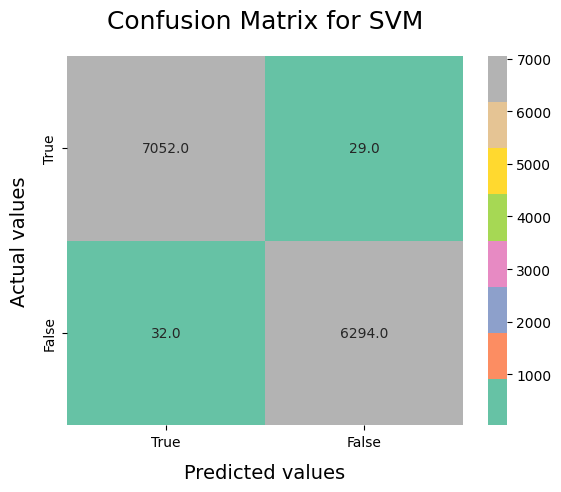

In [62]:
sns.heatmap(svm_matrix, annot=True,cmap = 'Set2',fmt = '.1f',
xticklabels = ['True', 'False'], yticklabels = ['True', 'False'])
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix for SVM", fontdict = {'size':18}, pad = 20)

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()

In [64]:
TNR = (tn/(tn+fp))
print('Specificity:', TNR)

TPR = (tp/(tp+fn))
print('Sensitivity:', TPR)

FPR = (fp/(tn+fp))
print('False Positive Rate:', FPR)

Specificity: 0.9959045332580144
Sensitivity: 0.9949415112235219
False Positive Rate: 0.004095466741985595


# Comparing Accuracies

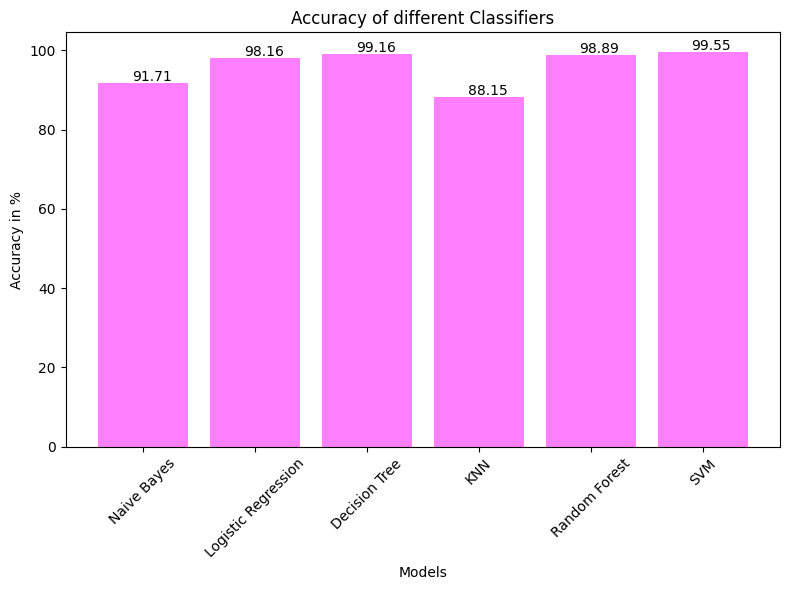

In [84]:
model = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'KNN', 'Random Forest', 'SVM']
accuracy = [accn_score, accl_score, accd_score, acck_score, accrf_score, svm_acc]

y_pos = np.arange(len(model))

plt.figure(figsize=(8,6))
plt.bar(y_pos, accuracy, align='center', alpha=0.5, color='fuchsia')
plt.xticks(y_pos, model, rotation=45)
plt.xlabel('Models')
plt.ylabel('Accuracy in %')
plt.title('Accuracy of different Classifiers')
plt.tight_layout()

# Add labels for the bars
for i in range(len(accuracy)):
  plt.text(x=i-0.1, y=accuracy[i]+0.5, s=str(accuracy[i]))

plt.show()

**From the above plot we can see that SVM is giving highest accuracy**

# Saving the trained model

In [ ]:
import pickle
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb')) #writing a file in a binary format
pickle.dump(svmclf, open('model.pkl', 'wb')) #writing a file in a binary format